# Using plantCV to extract phenotypes from the mask
J. Cristiano

The goals of this notebook are to: 
 - extract all phenotypes possible from Brace root masks
 - demonstrate on the ground truths, then try to get it working as well as possible on the predictions

The phenotypes that need to be extracted(taken from my first data collection survey): 
- [x] Marker width (Easy)
- [x] Stalk width (Easy)
- [] Root count (Hard)
- [] Average Root Width (HARD) 
- [] Height of top emergence (hard)
- [] Point of grounding (hard)

### Step 1: Loading the dataset


In [264]:
import os
print(os.getcwd())
os.chdir('/work/')

/work


In [265]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
from PadSquare import PadSquare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
coco_roots = [#'/work/2021_annot/images',
            #   '/work/2022_annot/images',
              '/work/2023_annot/images',
              '/work/2024_annot/images']

coco_annFiles = [#'/work/2021_annot/2021_annotations.json',
                 #'/work/2022_annot/2022_annotations.json',
                 '/work/2023_annot/2023_annotations_corrected.json',
                 '/work/2024_annot/2024_annotations.json']
standard_transform = transforms.v2.Compose([
    PadSquare(0),
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
full_dataset = datasets.CocoDetection(root=coco_roots[0], annFile=coco_annFiles[0], transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("labels", "masks"))
for coco_root, coco_annFile in zip(coco_roots[1:], coco_annFiles[1:]):
    seasonal_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
    seasonal_dataset = datasets.wrap_dataset_for_transforms_v2(seasonal_dataset, target_keys=("labels", "masks"))
    full_dataset = torch.utils.data.ConcatDataset([full_dataset, seasonal_dataset])

def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    mask_batch = []
    for mask in masks:
        multiclass_mask = torch.zeros((4, mask["masks"].shape[1], mask["masks"].shape[2]), dtype=mask["masks"].dtype)
        for idx, label in enumerate(mask["labels"]):
            multiclass_mask[label] += mask["masks"][idx]
        multiclass_mask[0] = 255 - torch.max(multiclass_mask[1:], dim=0)[0]*255
        mask_batch.append(multiclass_mask)

    return images, mask_batch

dataloader = DataLoader(full_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)



Using device: cuda
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


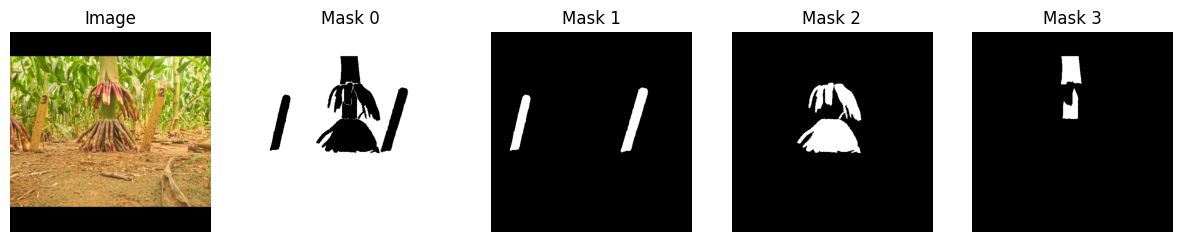

In [266]:
# load the first batch from the dataloader
images, masks = next(iter(dataloader))

# get the first image and mask from the batch
image = images[0]
mask = masks[0]  # mask is a tensor with shape (4, H, W)

# plot the image and each of the 4 mask channels
plt.figure(figsize=(15, 3))

# Plot the original image (convert PIL Image to a numpy array)
plt.subplot(1, 5, 1)
plt.imshow(np.transpose(np.array(image), (1, 2, 0)))
plt.title("Image")
plt.axis("off")

# Plot each mask channel
for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(mask[i].cpu().numpy(), cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.show()

### Easy task 1: Analysis of the scale marker
#### Mark 1: no graphical output

In [267]:
import numpy as np
from scipy.ndimage import label, find_objects, center_of_mass

def find_rectangular_width(mask, center_of_mass_thresh=None):
    """
    Finds the horizontal bounding width(s) of rectangular objects in a 512x512 mask.
    
    Parameters:
      mask (numpy.ndarray): 2D array (512x512) representing the mask. Nonzero values indicate object pixels.
      center_of_mass_thresh (float, optional): A y-coordinate threshold.
          The function returns the width of the first component whose center-of-mass (y coordinate)
          is less than this value ("above" in image coordinates).
          If None, the function returns the average width of all components.
    
    Returns:
      float: The width (in pixels) of the selected rectangular component or the average width.
    """
    # Ensure mask is binary
    binary_mask = (mask > 0).astype(np.uint8)
    
    # Label connected components in binary mask
    labeled, num_features = label(binary_mask)
    
    widths = []
    selected_width = None
    
    # Get bounding boxes for each connected component.
    objects = find_objects(labeled)
    for i, slc in enumerate(objects, start=1):
        # slc is a tuple (slice_y, slice_x)
        # Compute horizontal bounds (columns)
        left = slc[1].start
        right = slc[1].stop
        comp_width = right - left
        widths.append(comp_width)
        
        if center_of_mass_thresh is not None:
            # Calculate center of mass for this component; returns (y, x)
            com_y, _ = center_of_mass(binary_mask, labeled, i)
            # Check if center of mass is above the threshold (i.e., a smaller y value)
            if com_y < center_of_mass_thresh:
                selected_width = comp_width
                break
                
    if center_of_mass_thresh is not None:
        if selected_width is not None:
            return selected_width
        elif widths:
            return sum(widths) / len(widths)
        else:
            return 0.0
    else:
        if widths:
            return sum(widths) / len(widths)
        else:
            return 0.0
        
# Test the function
slice = mask[3]
width = find_rectangular_width(slice.cpu().numpy(), center_of_mass_thresh=None)
print(f"Average width: {width:.2f}")

Average width: 46.50


#### Mark 3: Graphical output, rotation; correct orientation 

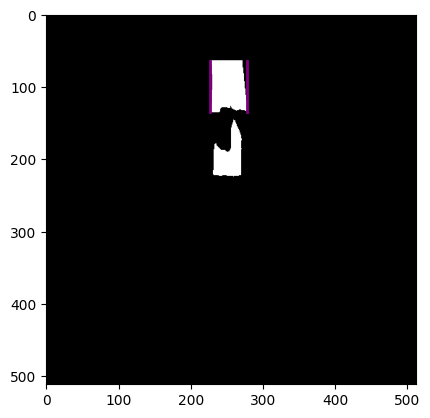

Bounding box (rotated): [[226  64]
 [278  64]
 [278 135]
 [226 135]]


In [268]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_rectangular_width(mask, center=None):
    """
    Finds the width of the rectangular object in a 512x512 binary mask
    in a way that best hugs its rotated edges. If a center (y, x) is given,
    only contours with center-of-mass above that y value are considered.
    If center is not provided, returns the average width among all contours.

    Parameters:
      mask (2D numpy array): A binary 512x512 mask.
      center (tuple, optional): (y, x) coordinate. Only consider contours whose
                                center-of-mass y is less than center[0].

    Returns:
      - If center is provided:
            best_box (numpy array): The 4 vertices of the best–fitting rotated
                                    rectangle (from cv2.boxPoints). The two edges
                                    corresponding to the smaller side have been
                                    identified as the object's width boundaries.
      - Otherwise:
            avg_width (float): The average width among all contours.
    """
    # Find external contours; ensure mask is uint8.
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []    # rotated rectangle vertices for each contour
    widths = []   # the smaller side (width) of each rectangle
    
    for cnt in contours:
        if cv2.contourArea(cnt) == 0:
            continue

        # Compute center of mass using moments.
        M = cv2.moments(cnt)
        cY = int(M['m01']/M['m00']) if M['m00'] != 0 else 0
        
        if center is not None and cY >= center[0]:
            continue

        # Get the minimum area rectangle that encloses the contour.
        rect = cv2.minAreaRect(cnt)  # rect = ((cx,cy), (w,h), angle)
        box = cv2.boxPoints(rect)      # get 4 vertices
        box = np.intp(box)
        
        # By convention, choose the smaller side as the true width.
        w, h = rect[1]
        rect_width = min(w, h)
        widths.append(rect_width)
        boxes.append(box)
    
    if center is not None:
        if widths:
            # Choose the region with the largest width (adjust as needed)
            idx = np.argmax(widths)
            best_box = boxes[idx]
            result = best_box
        else:
            result = None
    else:
        result = np.mean(widths) if widths else None

    # Plot the mask.
    plt.imshow(mask, cmap='gray')


    if center is not None:
        if result is not None:
            # Determine which rectangle edge is most vertical by checking x-coordinate differences.
            vertical_differences = [abs(result[i][0] - result[(i+1) % 4][0]) for i in range(4)]
            idx_edge = np.argmin(vertical_differences)
            p1 = result[idx_edge]
            p2 = result[(idx_edge+1)%4]
            # Also plot the opposite edge.
            opp_edge = (result[(idx_edge+2)%4], result[(idx_edge+3)%4])
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='purple', linewidth=2)
            plt.plot([opp_edge[0][0], opp_edge[1][0]], [opp_edge[0][1], opp_edge[1][1]], color='purple', linewidth=2)
    else:
        # When no center is provided, plot vertical edges for all regions.
        for box in boxes:
            vertical_differences = [abs(box[i][0] - box[(i+1)%4][0]) for i in range(4)]
            idx_edge = np.argmin(vertical_differences)
            p1 = box[idx_edge]
            p2 = box[(idx_edge+1)%4]
            opp_edge = (box[(idx_edge+2)%4], box[(idx_edge+3)%4])
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='purple', linewidth=2)
            plt.plot([opp_edge[0][0], opp_edge[1][0]], [opp_edge[0][1], opp_edge[1][1]], color='purple', linewidth=2)


    plt.show()
    return result

# Test the function
slice_mask = mask[3].cpu().numpy()  # assuming mask is defined
center = (350, 450)
bbox = find_rectangular_width(slice_mask, center)
print(f"Bounding box (rotated): {bbox}")

### Analysis of the root mask

In [269]:
import math
def measure_root_mask(root_mask, stalk_bbox):
    """
    Measure properties on a root mask.
    
    Parameters:
      root_mask: binary image (numpy array) where roots are white (non-zero)
      stalk_bbox: tuple (x, y, w, h) for the stalk bounding box
      
    Returns:
      dict with:
        - 'root_count': number of separated roots
        - 'avg_root_width': average width of individual roots
        - 'spread_width': horizontal distance between extreme root points
        - 'highest_emergence': (x, y) coordinate of the emergence spot
        - 'root_angle': angle (in degrees) between the stalk direction (vertical)
                        and the line from the spread width center to the emergence point
    """
    measurements = {}
    
    # Preprocess: noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(root_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area (dilate)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    # For sure foreground, use distance transform and threshold.
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Filter out unwanted contours: keep only the contour directly below the stalk_bbox.
    contours, _ = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Unpack stalk_bbox assuming format (x, y, w, h)
    stalk_x, stalk_y, stalk_w, stalk_h = stalk_bbox if not isinstance(stalk_bbox, np.ndarray) \
        else (int(np.min(stalk_bbox[:,0])), int(np.min(stalk_bbox[:,1])), int(np.ptp(stalk_bbox[:,0])), int(np.ptp(stalk_bbox[:,1])))
    target_contours = []
    print(f"Found {len(contours)} contours.")
    for i,cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        # Check for horizontal overlap with stalk_bbox and that the contour lies below it
        print(f"Contour {i}: x={x}, y={y}, w={w}, h={h}")
        print(f"Stalk bbox: x={stalk_x}, y={stalk_y}, w={stalk_w}, h={stalk_h}")
        # if (x + w > stalk_x) and (x < stalk_x + stalk_w) and (y > stalk_y + stalk_h):
        if (x + w > stalk_x) and (x < stalk_x + stalk_w):
            print("Found target contour.")
            target_contours.append(cnt)
            # break
    print(f"Found {len(target_contours)} target contours.")
    if target_contours is not None:
        mask_filtered = np.zeros_like(root_mask)
        for cnt in target_contours:
            masklet = np.zeros_like(root_mask)
            cv2.drawContours(masklet, [cnt], -1, 255, thickness=-1)
            mask_filtered = cv2.bitwise_or(mask_filtered, masklet)
        # cv2.drawContours(mask_filtered, [target_contours], -1, 255, thickness=-1)
    else:
        mask_filtered = root_mask
    # Root spread width: horizontal distance between furthest root mask points.
    pts = np.column_stack(np.where(mask_filtered>0))
    if pts.size:
        # Note: pts are in (row, col) so col->x coordinate.
        xs = pts[:,1]
        measurements['spread_width'] = int(xs.max() - xs.min())
    else:
        measurements['spread_width'] = 0

    # Highest emergence spot:
    # Use the largest contour as the main root system.
    if target_contours:
        largest_contour = max(target_contours, key=cv2.contourArea)
        # Get the stalk vertical line. For instance, take left side of stalk_bbox.
        
        stalk_x = stalk_bbox[1][0] if stalk_bbox[1][0] < stalk_bbox[3][0] else stalk_bbox[3][0]
        # Find intersection of largest contour with vertical line (all contour points with x≈stalk_x)
        # Allow small error tolerance
        tol = 5
        emergence_candidates = [pt[0] for pt in largest_contour if abs(pt[0][0] - stalk_x) < tol]
        if emergence_candidates:
            # From these candidates, take the one with minimum y (highest point)
            emergence_points = [pt[0] for pt in largest_contour if abs(pt[0][0] - stalk_x) < tol]
            highest_pt = min(emergence_points, key=lambda p: p[1])
            measurements['highest_emergence'] = (int(highest_pt[0]), int(highest_pt[1]))
        else:
            measurements['highest_emergence'] = None
    else:
        measurements['highest_emergence'] = None

    # Root angle:
    # Compute the center along the spread width line
    if pts.size and measurements['highest_emergence']:
        center_x = (xs.max() + xs.min())/2
        
        y_mean = np.max(pts[:,0]) - (np.max(pts[:,0]) - np.median(pts[:,0]))/2  # approximate vertical center of roots, lowered by 10 pixels
        spread_center = (center_x, y_mean)
        emergence = measurements['highest_emergence']
        # Stalk line is vertical. The angle is computed from the vertical:
        measurements['spread_center'] = spread_center
        dx = emergence[0] - xs.min()
        dy = spread_center[1] - emergence[1]
        # Angle between vertical and the line. Use arctan of the horizontal offset versus vertical.
        print(f"dx: {dx}, dy: {dy}")
        angle_rad = math.atan2(dx, dy)
        measurements['root_angle'] = math.degrees(angle_rad)
    else:
        measurements['root_angle'] = None

    return measurements

# Test the function
measure_root_mask(mask[2].cpu().numpy(), bbox)

Found 3 contours.
Contour 0: x=167, y=224, w=160, h=87
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Contour 1: x=261, y=134, w=68, h=94
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Contour 2: x=195, y=132, w=64, h=71
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Found 3 target contours.
dx: 61, dy: 55.5


{'spread_width': 161,
 'highest_emergence': (228, 224),
 'spread_center': (247.5, 279.5),
 'root_angle': 47.70294403781471}

Found 3 contours.
Contour 0: x=167, y=224, w=160, h=87
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Contour 1: x=261, y=134, w=68, h=94
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Contour 2: x=195, y=132, w=64, h=71
Stalk bbox: x=226, y=64, w=52, h=71
Found target contour.
Found 3 target contours.
dx: 61, dy: 55.5


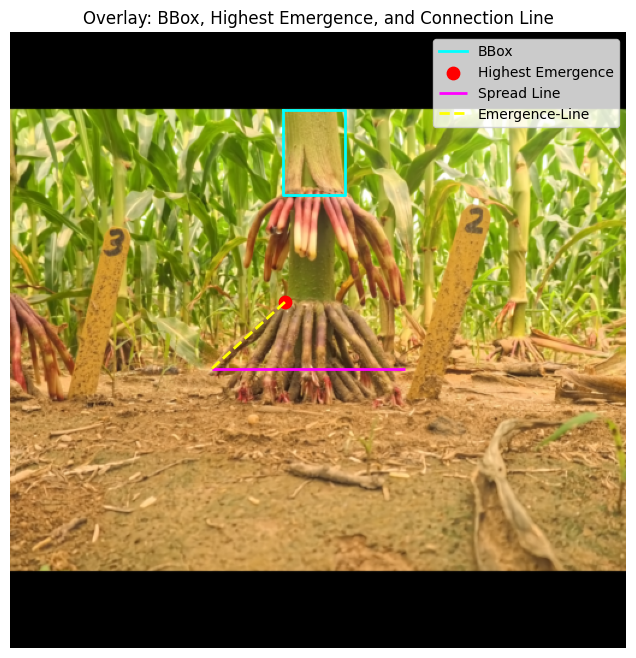

In [270]:
# Call the measurement function to get relevant metrics
measurements = measure_root_mask(mask[2].cpu().numpy(), bbox)
highest_emergence = measurements.get('highest_emergence', None)
spread_center = measurements.get('spread_center', None)

# Convert mask[0] to numpy array for plotting (assuming mask[0] is a torch.Tensor)
mask0 = mask[0].cpu().numpy()

# Create the figure and plot the mask background
plt.figure(figsize=(8, 8))
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title("Overlay: BBox, Highest Emergence, and Connection Line")
plt.axis('off')

# Plot the bounding box by closing the polygon (bbox is numpy array of shape (4,2))
bbox_closed = np.vstack([bbox, bbox[0]])
plt.plot(bbox_closed[:, 0], bbox_closed[:, 1], color='cyan', linewidth=2, label='BBox')

# Plot highest emergence if it exists
if highest_emergence is not None:
    plt.scatter(highest_emergence[0], highest_emergence[1], c='red', s=80, label='Highest Emergence')

# Plot the line from highest emergence to the spread_center if available
if spread_center is not None and measurements.get('spread_width', 0) > 0:
    half_width = measurements['spread_width'] / 2
    plt.hlines(spread_center[1],
                spread_center[0] - half_width,
                spread_center[0] + half_width,
                color='magenta',
                linestyle='-',
                linewidth=2,
                label='Spread Line')
    if highest_emergence is not None and spread_center is not None:
        # Draw a line from highest emergence to spread_center
        plt.plot([highest_emergence[0], spread_center[0]- half_width], [highest_emergence[1], spread_center[1]], 
             color='yellow', linestyle='--', linewidth=2, label='Emergence-Line')
plt.legend(loc='upper right')
plt.show()